In [354]:
import matplotlib.pyplot as plt
import scipy
import sympy
import numpy as np
import control 
import os
import array_to_latex as a2l
from ControlTheoryToolbox import System, CToolbox
import cvxpy
from sympy import symbols
from sympy.matrices import Matrix
from sympy import MatrixSymbol
from sympy import init_printing
init_printing(use_unicode=True)

In [355]:
def task1_get_G(specs):
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    return new_g

In [356]:
def task1_get_K(A, B, G, Y):
    P= cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(A @ P - P @ G - B @ Y))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    return - Y @ np.linalg.pinv(P.value), P.value

In [357]:
def task1(system : System, QRs : list, x0 : np.array, time_end = 3.0):
    # remind that closed loop looks like A - BK, not A + BK

    time = np.linspace(0, time_end, 10000)
    dt = time_end / 10000.0

    colors = ['blue', 'r', 'green', 'orange']
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)
    fig_u, axs_u = plt.subplots(1, 2, figsize=(8, 4))
    fig_u.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)

    for j, (Q, R) in enumerate(QRs):
        if j <= 2:
            K, P, E = control.lqr(system.A, system.B, Q, R)
        else:
            desired_eigvalues = [-5, -5, -5, -5]
            Y = np.array([[1, 1, 1, 1], [1, 1, 1, 1]])
            G = task1_get_G(desired_eigvalues)
            K, P = task1_get_K(system.A, system.B, G, Y)
            K *= -1
            # E = 0
            # P = 0
        # print(E, np.linalg.eig(system.A - system.B @ K)[0]) 
        print(f'==============')
        print('Q: ', Q)
        print(a2l.to_ltx(Q, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print('R: ', R)
        print(a2l.to_ltx(R, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print('K: ', K)
        print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        print('P: ', P)
        print(a2l.to_ltx(P, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
        
        J = x0.T @ P @ x0

        print('J theory: ', J)
        # print(a2l.to_ltx(J, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

        ss = control.ss((system.A - system.B @ K), system.B*0, system.A * 0, system.B * 0)
        resp = control.forced_response(ss, X0=x0, T=time)

        # print(resp.states)
        J_h = 0
        for i, x in enumerate(resp.states.T):
            J_h += (x @ Q @ x.T + (-K@x.T) @ R @ (-K@x.T).T) * dt

        print('J approx: ', J_h)

        for i in range(system.A.shape[0]):
            idx = (i // 2, i % 2)
        
            axs[idx].plot(time, resp.states[i], linewidth=2, label=f"Q = {Q}, R = {R}", color=colors[j], linestyle='-')
            axs[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs[idx].grid(True)
            # axs[idx].legend()

        for i in range(2):
            idx = i
            axs_u[idx].plot(time[100:], (-K@resp.states)[i][100:], linewidth=2, label=f"Q = {Q}, R = {R}", color=colors[j], linestyle='-')
            axs_u[idx].set_title(f'x_{i}(t)', fontsize=12)
            axs_u[idx].set_xlabel(f"t, [c]", fontsize=12)
            axs_u[idx].grid(True)
        # print(a2l.to_ltx(J, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

In [358]:
A = np.array([
    [-6, 19, -13, 10],
    [0, -9, 6, 0],
    [0, -15, 9, 0],
    [-4, 8, -7, 6]
])
B = np.array([
    [-1, 0],
    [1, 0],
    [2, 0],
    [0, 0]
])
C = np.array([
    [2, -6, 4, -2],
    [0, 12, -6, 0]
])
D = np.array([
    [0, 0],
    [0, 4]
])
x0 = np.ones(A.shape[0]).T
Q = np.eye(4)
R = np.eye(2)
system = System(A, B, A*0, B*0)
QRs = [(100000000000*Q, 0.000001*R)]
# Q[0][0] = 100
# Q[3][3] = 10
QRs.append((Q, R))

In [359]:
CToolbox.check_eigenvalues_controllable(A, B, method = 'jordan_form')

jordan_form  [1/2 -1/2 - I/2 -1/2 + I/2 1/2 0 0 0 0]


array([ True,  True,  True,  True])

In [360]:
np.linalg.eig(A)[0]

array([-3.74700271e-16+2.j, -3.74700271e-16-2.j, -3.05311332e-16+3.j,
       -3.05311332e-16-3.j])

Q:  [[1.e+11 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+11 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+11 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+11]]
\begin{bmatrix}
  100000000000.00 &  0.00 &  0.00 &  0.00\\
  0.00 &  100000000000.00 &  0.00 &  0.00\\
  0.00 &  0.00 &  100000000000.00 &  0.00\\
  0.00 &  0.00 &  0.00 &  100000000000.00
\end{bmatrix}
R:  [[1.e-06 0.e+00]
 [0.e+00 1.e-06]]
\begin{bmatrix}
  0.00 &  0.00\\
  0.00 &  0.00
\end{bmatrix}
K:  [[ 8.61855957e+08 -1.46681152e+09  1.55163232e+09 -1.69812451e+09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
\begin{bmatrix}
  861855957.03 & -1466811523.44 &  1551632324.22 & -1698124511.72\\
  0.00 &  0.00 &  0.00 &  0.00
\end{bmatrix}
P:  [[ 5.78377010e+11 -9.44951721e+11  7.61664366e+11 -9.47915055e+11]
 [-9.44951721e+11  1.96397010e+12 -1.45446091e+12  1.85483366e+12]
 [ 7.61664366e+11 -1.45446091e+12  1.10806264e+12 -1.40137436e+12]
 [-9.47915055e+11  1.85483366e+12 -1.40137436e+12  1.81182746e+12]]
\begin{bmatrix}
  5783770

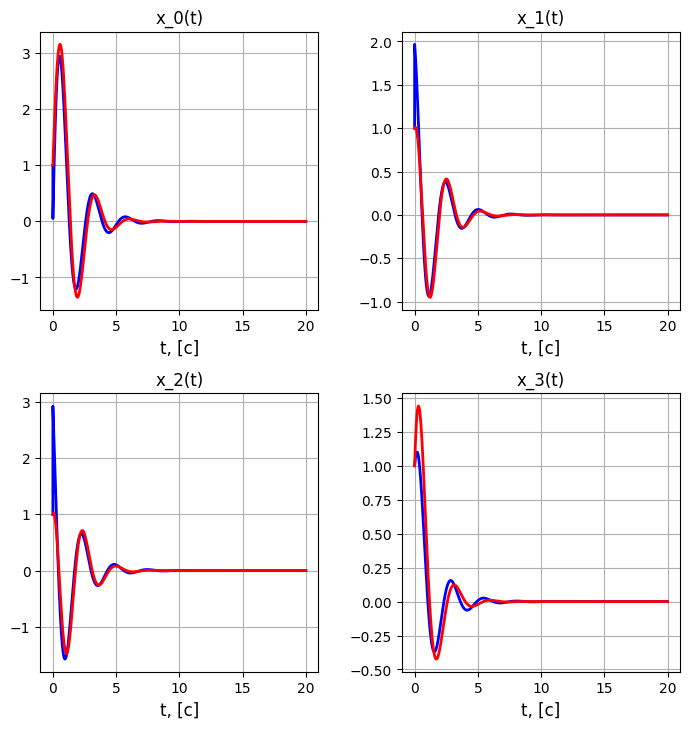

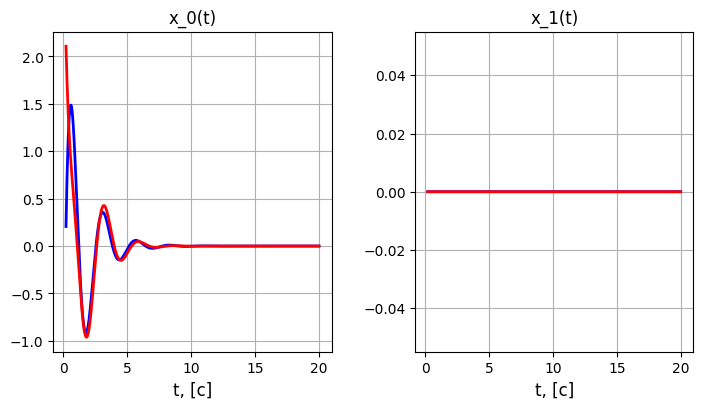

In [361]:
task1(system, QRs, x0, time_end=20.0)